# Jonathan Halverson
# Friday, February 24, 2017
# Part 5: Orthodox versus southpow stance

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('halverson')
%matplotlib inline

In [2]:
fights = pd.read_csv('fightmetric_cards/fightmetric_fights.csv', header=0, parse_dates=['Date'])
fighters = pd.read_csv('fightmetric_fighters/fightmetric_fighters.csv', header=0, parse_dates=['Dob'])
fighters['Age'] = (pd.to_datetime('today') - fighters.Dob) / np.timedelta64(1, 'Y')
cols = ['Name', 'Height', 'Reach', 'Stance', 'Dob', 'Age']
df = fights.merge(fighters[cols], how='inner', left_on='Winner', right_on='Name')
df = df.merge(fighters[cols], how='inner', left_on='Loser', right_on='Name', suffixes=('', '_L'))

# Orthodox versus Southpaw stance

Here we remove draws and consider fights from 2005 and later.

In [28]:
ortho_south = df[(df.Outcome.isin(['def.'])) & (df.Date > np.datetime64('2005-01-01'))].copy()
msk1 = ((ortho_south.Stance == 'Orthodox') & (ortho_south.Stance_L == 'Southpaw'))
msk2 = ((ortho_south.Stance == 'Southpaw') & (ortho_south.Stance_L == 'Orthodox'))
cols = ['Winner', 'Outcome', 'Loser', 'Stance', 'Stance_L', 'Reach', 'Reach_L', 'Age', 'Age_L']
ortho_south = ortho_south[msk1 | msk2][cols]
ortho_south[:10]

,Winner,Outcome,Loser,Stance,Stance_L,Reach,Reach_L,Age,Age_L
0,Germaine de Randamie,def.,Holly Holm,Orthodox,Southpaw,71.0,69.0,32.838457,35.357331
2,Miesha Tate,def.,Holly Holm,Orthodox,Southpaw,65.0,69.0,30.522187,35.357331
10,Robert Whittaker,def.,Derek Brunson,Orthodox,Southpaw,73.0,77.0,26.182605,33.142364
15,Carlos Condit,def.,Nick Diaz,Orthodox,Southpaw,75.0,76.0,32.832981,33.566740
16,Georges St-Pierre,def.,Nick Diaz,Orthodox,Southpaw,76.0,76.0,35.770755,33.566740
17,Sean Sherk,def.,Nick Diaz,Orthodox,Southpaw,67.0,76.0,43.557363,33.566740
19,Anderson Silva,def.,Stephan Bonnar,Southpaw,Orthodox,77.0,78.0,41.868074,39.894043
29,Jon Jones,def.,Chael Sonnen,Orthodox,Southpaw,84.0,74.0,29.604988,39.896781
30,Rashad Evans,def.,Chael Sonnen,Orthodox,Southpaw,75.0,74.0,37.418975,39.896781
31,Renato Sobral,def.,Chael Sonnen,Orthodox,Southpaw,75.0,74.0,41.468340,39.896781


In [30]:
total_fights = ortho_south.shape[0]
total_fights

1017

In [44]:
f = ortho_south.Winner.append(ortho_south.Loser).unique()
cont_table = fighters[fighters.Name.isin(f)].groupby('Stance').agg({'Height':[np.size, np.mean, np.std], 'Reach':[np.mean, np.std], 'Age':[np.mean, np.std]})
cont_table.astype({('Height', 'size'):int}).applymap(lambda x: round(x, 3))

Age          Reach        Height               
            mean    std    mean    std   size    mean    std
Stance                                                      
Orthodox  33.954  4.959  72.342  3.810  535.0  70.637  3.128
Southpaw  33.894  5.109  71.967  3.569  212.0  70.486  3.031

In [23]:
w_ortho = ortho_south[(ortho_south.Stance == 'Orthodox') & (ortho_south.Outcome == 'def.')].shape[0]
w_south = ortho_south[(ortho_south.Stance == 'Southpaw') & (ortho_south.Outcome == 'def.')].shape[0]
l_ortho = ortho_south[(ortho_south.Stance_L == 'Orthodox') & (ortho_south.Outcome == 'def.')].shape[0]
l_south = ortho_south[(ortho_south.Stance_L == 'Southpaw') & (ortho_south.Outcome == 'def.')].shape[0]

In [24]:
cont_table = pd.DataFrame([[w_ortho, w_south], [l_ortho, l_south]])
cont_table.columns = ['Orthodox', 'Southpaw']
cont_table.index=['ortho_south', 'Losses']
cont_table

,Orthodox,Southpaw
Wins,454,563
Losses,563,454


In [25]:
454+563

1017

In [26]:
from scipy.stats import chisquare

chi_sq_stat, p_value = chisquare([w_ortho, w_south], [0.5 * 1017, 0.5 * 1017])
chi_sq_stat, p_value

(11.682399213372666, 0.00063094119863635291)

In [27]:
from scipy.stats import binom
2 * sum([binom.pmf(k, n=1017, p=0.5) for k in range(0, 454 + 1)])

0.00070017124661251185

In [10]:
p_value = 2 * binom.cdf(k=454, n=1017, p=0.5)
p_value

0.00070017124661233415

In [11]:
1.0 - binom.cdf(k=563, n=1017, p=0.5)

0.00027780863640225473

In [12]:
binom.cdf(k=454, n=1017, p=0.5)

0.00035008562330616708

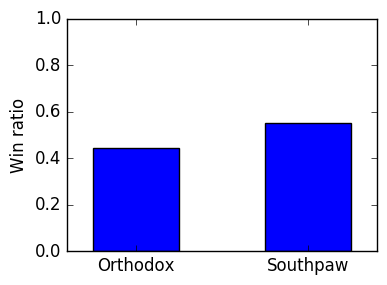

In [13]:
fig = plt.figure(1, figsize=(4, 3))
win_ratio = [float(w_ortho) / ortho_south.shape[0], float(w_south) / ortho_south.shape[0]]
plt.bar(range(cont_table.shape[0]), win_ratio, width=0.5, tick_label=cont_table.columns.values, align='center')
plt.ylim(0, 1)
plt.ylabel('Win ratio')

In [14]:
win_ratio

[0.4446620959843291, 0.5514201762977473]

### What if reach and age are approximately the same?

In [15]:
stance_reach = ortho_south.copy()

stance_reach['ReachDiff'] = stance_reach.Reach - stance_reach.Reach_L
stance_reach.ReachDiff = stance_reach.ReachDiff.abs()
stance_reach['AgeDiff'] = stance_reach.Age - stance_reach.Age_L
stance_reach.AgeDiff = stance_reach.AgeDiff.abs()
stance_reach = stance_reach[(stance_reach.ReachDiff <= 3.0) & (stance_reach.AgeDiff <= 3.0)]
w_ortho = stance_reach[(stance_reach.Stance == 'Orthodox') & (stance_reach.Outcome == 'def.')].shape[0]
w_south = stance_reach[(stance_reach.Stance == 'Southpaw') & (stance_reach.Outcome == 'def.')].shape[0]
l_ortho = stance_reach[(stance_reach.Stance_L == 'Orthodox') & (stance_reach.Outcome == 'def.')].shape[0]
l_south = stance_reach[(stance_reach.Stance_L == 'Southpaw') & (stance_reach.Outcome == 'def.')].shape[0]

In [16]:
stance_reach[:10]

,Winner,Outcome,Loser,Stance,Stance_L,Reach,Reach_L,Age,Age_L,ReachDiff,AgeDiff
0,Germaine de Randamie,def.,Holly Holm,Orthodox,Southpaw,71.0,69.0,32.838457,35.357331,2.0,2.518874
15,Carlos Condit,def.,Nick Diaz,Orthodox,Southpaw,75.0,76.0,32.832981,33.566740,1.0,0.733759
16,Georges St-Pierre,def.,Nick Diaz,Orthodox,Southpaw,76.0,76.0,35.770755,33.566740,0.0,2.204015
19,Anderson Silva,def.,Stephan Bonnar,Southpaw,Orthodox,77.0,78.0,41.868074,39.894043,1.0,1.974031
30,Rashad Evans,def.,Chael Sonnen,Orthodox,Southpaw,75.0,74.0,37.418975,39.896781,1.0,2.477806
31,Renato Sobral,def.,Chael Sonnen,Orthodox,Southpaw,75.0,74.0,41.468340,39.896781,1.0,1.571559
32,Jeremy Horn,def.,Chael Sonnen,Orthodox,Southpaw,74.0,74.0,41.503932,39.896781,0.0,1.607151
34,Jacare Souza,def.,Yushin Okami,Orthodox,Southpaw,72.0,72.0,37.219108,35.598267,0.0,1.620841
35,Tim Boetsch,def.,Yushin Okami,Orthodox,Southpaw,74.0,72.0,36.074663,35.598267,2.0,0.476396
39,Jacare Souza,def.,Vitor Belfort,Orthodox,Southpaw,72.0,74.0,37.219108,39.902257,2.0,2.683149


In [17]:
cont_table = pd.DataFrame([[w_ortho, w_south], [l_ortho, l_south]])
cont_table.columns = ['Orthodox', 'Southpaw']
cont_table.index=['ortho_south', 'Losses']
cont_table

,Orthodox,Southpaw
Wins,133,187
Losses,187,133


In [18]:
chi_sq, p_value = chisquare([133, 187])
print chi_sq, p_value, p_value > 0.05

9.1125 0.00253868673815 False


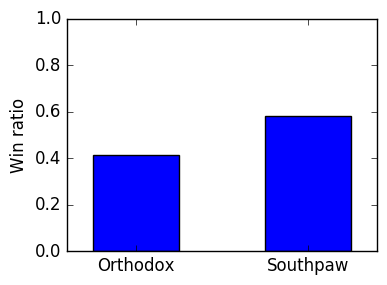

In [19]:
fig = plt.figure(1, figsize=(4, 3))
win_ratios = [float(w_ortho) / stance_reach.shape[0], float(w_south) / stance_reach.shape[0]]
plt.bar(range(cont_table.shape[0]), win_ratios, width=0.5, tick_label=cont_table.columns.values, align='center')
plt.ylim(0, 1)
plt.ylabel('Win ratio')

In [20]:
win_ratios

[0.415625, 0.584375]